In [176]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

import plotly 
import plotly.express as px
# from plotly import tools, subplots
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# row 생략 없이 출력
# pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)
from sklearn.metrics import mean_absolute_error

In [177]:
rawtest = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_test.csv")
rawtrain = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_train.csv")

In [178]:
test = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_test.csv")
train = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_train.csv")

In [179]:
# merged_ data에서 drop해야 할 단지코드
print(train.shape, test.shape)
train = train.loc[~train.단지코드.isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']),]
test = test.loc[~test.단지코드.isin(['C2335', 'C1327', 'C2675'])]
print(train.shape, test.shape)

(2896, 34) (1008, 33)
(2896, 34) (1008, 33)


In [180]:
train.at[range(1481,1487),"총세대수"]=969
train.at[range(1624,1632),"총세대수"]=969
train.at[range(1481,1487),"공가수"]=9
train.at[range(1624,1632),"공가수"]=9

train.at[range(1753,1757),"총세대수"]=1047
train.at[range(1810,1812),"총세대수"]=1047
train.at[range(1753,1757),"공가수"]=31
train.at[range(1810,1812),"공가수"]=31
train.at[range(1753,1757),"등록차량수"]=1214
train.at[range(1810,1812),"등록차량수"]=1214
train.at[range(1753,1757),"버스정류장"]=4
train.at[range(1810,1812),"버스정류장"]=4

In [181]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [182]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


In [183]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [184]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [185]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

In [186]:
data = train.drop(columns = [ '공급유형','자격유형_카테고리','단지명', '도로명주소', 'subway_name'])
data = data.drop_duplicates()
data = data.groupby('단지코드').mean()

In [187]:
dat = test.drop(columns = [ '공급유형','자격유형_카테고리','단지명', '도로명주소', 'subway_name'])
dat = dat.drop_duplicates()
dat = dat.groupby('단지코드').mean()

In [188]:
data = pd.merge(data,train[["단지코드","지역"]].drop_duplicates(),on = "단지코드")
dat = pd.merge(dat ,test[["단지코드","지역"]].drop_duplicates(),on = "단지코드")

In [189]:
tr_a = rawtrain[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").mean()[["임대보증금","임대료","전용면적","전용면적별세대수"]].reset_index()
tst_a = rawtest[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").mean()[["임대보증금","임대료","전용면적","전용면적별세대수"]].reset_index()

In [190]:
data = data.drop(columns = ["임대보증금","임대료","전용면적","전용면적별세대수"])
dat = dat.drop(columns = ["임대보증금","임대료","전용면적","전용면적별세대수"])
data["임대보증금"] = list(tr_a["임대보증금"])
data["임대료"] = list(tr_a["임대료"])
data["전용면적"] = list(tr_a["전용면적"])
data["전용면적별세대수"] = list(tr_a["전용면적별세대수"])

dat["임대보증금"] = list(tst_a["임대보증금"])
dat["임대료"] = list(tst_a["임대료"])
dat["전용면적"] = list(tst_a["전용면적"])
dat["전용면적별세대수"] = list(tst_a["전용면적별세대수"])


In [191]:
data.shape, tr_a.shape

((414, 32), (414, 5))

In [192]:
set(rawtrain.columns)-set(data.columns)

{'subway_name', '공급유형', '단지명', '도로명주소', '임대건물구분', '자격유형'}

In [193]:
data.columns

Index(['단지코드', '총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '연면적', '위도',
       '경도', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적', '지역',
       '임대보증금', '임대료', '전용면적', '전용면적별세대수'],
      dtype='object')

In [194]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [195]:
pd.set_option('display.max_rows', None)
tt = train.loc[train.공급유형 != "임대상가",["단지코드","공급유형"]].drop_duplicates()
tt = tt.groupby("단지코드").nunique()!=1
tt = tt.reset_index()
ty = train.loc[train.공급유형 != "임대상가",["단지코드","공급유형"]].drop_duplicates()
ty
ty[ty.단지코드.isin(tt["단지코드"][tt.공급유형 == True])]

,단지코드,공급유형
212,C1722,공공임대(50년)
215,C1722,영구임대
252,C1983,공공임대(50년)
255,C1983,영구임대
425,C2644,공공임대(50년)
427,C2644,영구임대
1643,C1344,공공임대(단기)
1645,C1344,공공임대(분납)
1727,C2085,장기전세
1733,C2085,공공임대(단기)


In [196]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '자격유형_카테고리'],
      dtype='object')

In [197]:
tmp = pd.get_dummies(train[["공급유형",'자격유형_카테고리','임대건물구분']])
tmp["단지코드"] = train["단지코드"]
tmp2 = pd.get_dummies(test[["공급유형",'자격유형_카테고리','임대건물구분']])
tmp2["단지코드"] = test["단지코드"]
data = pd.merge(data,tmp.groupby("단지코드").sum().reset_index(), on = "단지코드")
dat = pd.merge(dat,tmp2.groupby("단지코드").sum().reset_index(), on = "단지코드")

### 전용면적, 전용면적별세대수 

In [198]:
tr_gr = data
tst_gr = dat

In [199]:
tr_gr["전용면적_std"] = rawtrain[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["전용면적"]
tr_gr["전용면적별세대수_std"] = rawtrain[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["전용면적별세대수"]
tr_gr["임대보증금_std"] = rawtrain[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["임대보증금"]
tr_gr["임대료_std"] = rawtrain[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["임대료"]

tst_gr["전용면적_std"] = rawtest[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["전용면적"]
tst_gr["전용면적별세대수_std"] = rawtest[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["전용면적별세대수"]
tst_gr["임대보증금_std"] = rawtest[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["임대보증금"]
tst_gr["임대료_std"] = rawtest[rawtrain.임대건물구분 =="아파트"].groupby("단지코드").std().reset_index()["임대료"]

tr_gr.loc[tr_gr.전용면적_std.isna(),"전용면적_std"] = 0
tr_gr.loc[tr_gr.전용면적별세대수_std.isna(),"전용면적별세대수_std"] = 0
tr_gr.loc[tr_gr.임대보증금_std.isna(),"임대보증금_std"] = 0
tr_gr.loc[tr_gr.임대료_std.isna(),"임대료_std"] = 0

In [200]:
tr_gr

,단지코드,총세대수,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,연면적,위도,경도,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,0~19세_비율,20~39세_비율,40~69세_비율,70세이상_비율,상가비율,세대당_가능주차면수,공가수비율,대형전용면적,지역,임대보증금,임대료,전용면적,전용면적별세대수,공급유형_공공분양,공급유형_공공임대(50년),공급유형_공공임대(단기),공급유형_공공임대(분납),공급유형_국민임대,공급유형_영구임대,공급유형_임대상가,공급유형_장기전세,공급유형_행복주택,자격유형_카테고리_1,자격유형_카테고리_2,자격유형_카테고리_3,자격유형_카테고리_4,자격유형_카테고리_5,자격유형_카테고리_6,자격유형_카테고리_7,임대건물구분_상가,임대건물구분_아파트,전용면적_std,전용면적별세대수_std,임대보증금_std,임대료_std
0,C1000,566.0000,10.0000,0.0000,1.0000,438.0000,481.0000,"5,997.7100",127.6466,37.1098,0.1739,1.0000,"9,912.0000",1.9000,1.0300,1.5114,1.1905,1.1220,0.7294,0.1258,0.1810,0.5179,0.1753,0.0000,0.7739,0.0177,0.0000,충청북도,"13,203,571.4286","121,064.2857",45.2186,80.8571,0,0,0,0,7,0,0,0,0,7,0,0,0,0,0,0,0,7,5.5811,106.5183,"2,298,347.2944","24,854.2960"
1,C1004,521.0000,3.0000,0.0000,2.0000,153.0000,93.0000,948.7600,127.1337,36.8240,0.0181,1.0000,"21,296.0000",1.6550,1.1400,1.7826,1.2580,1.1829,0.6887,0.0968,0.3980,0.4273,0.0778,0.8667,0.2937,0.0058,0.0667,충청남도,"4,705,000.0000","104,695.0000",39.4950,252.0000,0,0,0,0,0,2,13,0,0,0,2,0,0,0,0,13,13,2,0.2758,16.9706,"32,526.9119",728.3200
2,C1005,"1,144.0000",16.0000,0.0000,8.0000,950.0000,376.0000,5.6880,127.1193,36.8210,0.0257,1.0000,"40,542.0000",2.8200,1.0100,2.1029,1.0075,1.0221,0.6470,0.2752,0.2915,0.3996,0.0337,0.0000,0.8304,0.0140,0.0000,충청남도,"17,107,666.6667","222,046.6667",54.3600,381.3333,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,4.5784,192.0555,"1,441,397.3544","21,445.4805"
3,C1013,"1,308.0000",16.0000,0.0000,6.0000,"1,119.0000","1,665.0000","7,272.9040",126.8715,35.1702,0.0187,1.0000,"16,229.0000",2.5700,0.9000,1.6395,0.9917,0.8646,0.6269,0.2430,0.2207,0.4692,0.0672,0.0000,0.8555,0.0122,0.0000,광주광역시,"24,924,800.0000","134,726.0000",46.1420,261.6000,0,0,0,0,5,0,0,0,0,5,0,0,0,0,0,0,0,5,4.3369,163.1236,"3,233,078.2855","17,036.8859"
4,C1014,996.0000,5.0000,0.0000,2.0000,823.0000,708.0000,"6,141.5100",127.3694,35.4002,0.5158,1.0000,"6,632.0000",2.1200,0.9400,1.6454,1.0959,0.9968,0.5984,0.1957,0.1846,0.4643,0.1555,0.0000,0.8263,0.0050,0.0000,전라북도,"23,894,000.0000","160,488.5714",49.2329,142.2857,0,0,0,0,7,0,0,0,0,7,0,0,0,0,0,0,0,7,8.9943,170.0232,"7,448,971.2041","18,903.5256"
5,C1015,961.0000,28.0000,0.0000,3.0000,928.0000,579.0000,"8,215.0700",128.8337,35.1517,0.0858,1.0000,"34,231.0000",2.1200,1.1600,2.9983,1.2687,1.2020,0.7197,0.2019,0.3022,0.4305,0.0654,0.0000,0.9657,0.0291,0.0000,부산광역시,"15,871,250.0000","136,192.5000",46.0475,120.1250,0,0,0,0,8,0,0,0,0,8,0,0,0,0,0,0,0,8,9.4573,112.2846,"6,456,388.7463","47,470.6591"
6,C1017,"1,460.0000",27.0000,0.0000,2.0000,"1,534.0000","1,246.0000",34.7600,127.3461,36.3404,0.0141,1.0000,"45,840.0000",2.4200,0.9200,2.1671,0.9294,0.8716,0.6995,0.2288,0.2761,0.4425,0.0527,0.0000,1.0507,0.0185,0.0000,대전광역시,"19,917,000.0000","229,706.6667",36.8367,486.6667,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,10.0559,141.3836,"11,884,282.0986","70,281.0944"
7,C1022,389.0000,4.0000,0.0000,4.0000,352.0000,450.0000,"4,287.2250",127.1496,37.2955,0.0213,1.0000,"39,189.0000",2.6300,0.9400,1.7812,1.0114,0.9060,0.7493,0.2027,0.2157,0.4578,0.1239,0.0000,0.9049,0.0103,0.0000,경기도,"24,665,000.0000","221,980.0000",46.9000,97.2500,0,0,0,0,4,0,0,0,0,4,0,0,0,0,0,0,0,4,0.0000,40.2026,0.0000,0.0000
8,C1024,680.0000,2.0000,0.0000,3.0000,877.0000,957.0000,"7,321.5700",127.1014,37.4748,0.0109,2.0000,"43,782.0000",2.4400,0.9000,1.8684,0.8760,0.9134,0.7503,0.2025,0.2688,0.4320,0.0967,0.0000,1.2897,0.0029,0.0000,서울특별시,"103,772,700.0000","970,947.0000",78.4230,47.7000,0,0,10,0,0,0,0,0,0,10,0,0,0,0,0,0,0,10,8.1657,46.2074,"16,163,394.7002","121,856.4296"
9,C1026,290.0000,10.0000,0.0000,2.0000,205.0000,422.0000,37.3800,128.4503,35.8233,0.0374,1.0000,"8,379.0000",2.0400,1.0800,1.7768,1.2554,1.1761,0.7010,0.1441,0.1739,0.5205,0.1616,0.0000,0.7069,0.0345,0.0000,경상북도,"24,147,500.0000","109,280.0000",55.8250,145.0000,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,2,5.8902,49.4975,"1,798,172.5446","17,960.5122"


In [201]:
X = tr_gr.drop(["단지코드","등록차량수"],axis=1)
y = tr_gr["등록차량수"]
X_tst = tst_gr.drop(["단지코드"],axis=1)
X_tr = X.loc[:,X_tst.columns]

In [203]:
X.columns

Index(['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적', '지역',
       '임대보증금', '임대료', '전용면적', '전용면적별세대수', '공급유형_공공분양', '공급유형_공공임대(50년)',
       '공급유형_공공임대(단기)', '공급유형_공공임대(분납)', '공급유형_국민임대', '공급유형_영구임대', '공급유형_임대상가',
       '공급유형_장기전세', '공급유형_행복주택', '자격유형_카테고리_1', '자격유형_카테고리_2', '자격유형_카테고리_3',
       '자격유형_카테고리_4', '자격유형_카테고리_5', '자격유형_카테고리_6', '자격유형_카테고리_7', '임대건물구분_상가',
       '임대건물구분_아파트', '전용면적_std', '전용면적별세대수_std', '임대보증금_std', '임대료_std'],
      dtype='object')

In [156]:
X_tst.shape, X.shape

((147, 51), (414, 54))

In [157]:
tr_gr.columns

Index(['단지코드', '총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '연면적', '위도',
       '경도', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적',
       '지역_x', '지역_y', '지역', '임대보증금', '임대료', '전용면적', '전용면적별세대수', '공급유형_공공분양',
       '공급유형_공공임대(50년)', '공급유형_공공임대(단기)', '공급유형_공공임대(분납)', '공급유형_국민임대',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_장기전세', '공급유형_행복주택', '자격유형_카테고리_1',
       '자격유형_카테고리_2', '자격유형_카테고리_3', '자격유형_카테고리_4', '자격유형_카테고리_5',
       '자격유형_카테고리_6', '자격유형_카테고리_7', '임대건물구분_상가', '임대건물구분_아파트', '전용면적_std',
       '전용면적별세대수_std', '임대보증금_std', '임대료_std'],
      dtype='object')

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021,shuffle=True)

In [159]:
from pandas.api.types import is_numeric_dtype
num_col = []
obj_col = []
for c in X_train.columns:
    if is_numeric_dtype(X_train[c]): num_col.append(c)
    else:obj_col.append(c)

In [160]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[num_col])

X_train_tmp = scaler.transform(X_train[num_col])
X_test_tmp = scaler.transform(X_test[num_col])

In [161]:
X_train = pd.concat([X_train[obj_col].reset_index(drop=True),pd.DataFrame(X_train_tmp)],axis=1)
X_test = pd.concat([X_test[obj_col].reset_index(drop=True),pd.DataFrame(X_test_tmp)],axis=1)

## Linear

In [237]:
X = pd.concat([X,pd.get_dummies(X.지역)],axis=1)
X = X.drop(["지역"],axis=1)
X_tst= pd.concat([X_tst,pd.get_dummies(X_tst.지역)],axis=1)
# X_tst = X.drop(["지역"],axis=1)

AttributeError: 'DataFrame' object has no attribute '지역'

In [229]:
from sklearn.linear_model import LinearRegression
fit = LinearRegression().fit(X,y)
tst_predict = fit.predict(X_tst)

ValueError: could not convert string to float: '충청북도'

In [ ]:
mean_absolute_error(tr_predict,y)

## Catboost

In [162]:
from catboost import CatBoostRegressor

In [163]:
model = CatBoostRegressor(
    cat_features = obj_col,
    n_estimators = 600,
    loss_function = 'MAE',
    eval_metric = 'RMSE')

In [164]:
model.fit(X_train, y_train )

0:	learn: 398.6509892	total: 6.48ms	remaining: 3.88s
1:	learn: 391.9100991	total: 15.7ms	remaining: 4.7s
2:	learn: 386.8928564	total: 19.7ms	remaining: 3.91s
3:	learn: 382.0665774	total: 23.1ms	remaining: 3.44s
4:	learn: 378.0489512	total: 26.4ms	remaining: 3.14s
5:	learn: 373.4242063	total: 32.4ms	remaining: 3.21s
6:	learn: 368.8558328	total: 36.5ms	remaining: 3.09s
7:	learn: 364.2732304	total: 39.8ms	remaining: 2.95s
8:	learn: 360.3376748	total: 42.7ms	remaining: 2.8s
9:	learn: 355.8568447	total: 45.7ms	remaining: 2.69s
10:	learn: 351.5851761	total: 48.4ms	remaining: 2.59s
11:	learn: 346.7370569	total: 51.3ms	remaining: 2.51s
12:	learn: 343.3495958	total: 53.9ms	remaining: 2.43s
13:	learn: 339.9231708	total: 56.4ms	remaining: 2.36s
14:	learn: 335.3389559	total: 58.9ms	remaining: 2.3s
15:	learn: 330.8128483	total: 61.8ms	remaining: 2.26s
16:	learn: 327.1700185	total: 64.7ms	remaining: 2.22s
17:	learn: 324.3391736	total: 67.2ms	remaining: 2.17s
18:	learn: 321.6222025	total: 69.6ms	rema

218:	learn: 135.4705174	total: 589ms	remaining: 1.02s
219:	learn: 134.8656105	total: 592ms	remaining: 1.02s
220:	learn: 133.8777799	total: 594ms	remaining: 1.02s
221:	learn: 133.5145925	total: 597ms	remaining: 1.02s
222:	learn: 133.1314511	total: 599ms	remaining: 1.01s
223:	learn: 132.7511033	total: 602ms	remaining: 1.01s
224:	learn: 132.5695026	total: 604ms	remaining: 1.01s
225:	learn: 132.5381637	total: 606ms	remaining: 1s
226:	learn: 132.3338569	total: 609ms	remaining: 1s
227:	learn: 132.1469318	total: 612ms	remaining: 998ms
228:	learn: 131.9909676	total: 615ms	remaining: 996ms
229:	learn: 131.9193770	total: 618ms	remaining: 994ms
230:	learn: 129.9807317	total: 621ms	remaining: 992ms
231:	learn: 129.9047580	total: 623ms	remaining: 989ms
232:	learn: 129.7475196	total: 626ms	remaining: 985ms
233:	learn: 129.5100383	total: 628ms	remaining: 982ms
234:	learn: 127.6520492	total: 631ms	remaining: 980ms
235:	learn: 127.6151951	total: 633ms	remaining: 977ms
236:	learn: 127.5694185	total: 636

436:	learn: 88.9154182	total: 1.17s	remaining: 435ms
437:	learn: 88.8224847	total: 1.17s	remaining: 432ms
438:	learn: 88.3801468	total: 1.17s	remaining: 430ms
439:	learn: 88.3750940	total: 1.17s	remaining: 427ms
440:	learn: 88.3726734	total: 1.18s	remaining: 424ms
441:	learn: 88.1964718	total: 1.18s	remaining: 422ms
442:	learn: 88.1331961	total: 1.18s	remaining: 419ms
443:	learn: 88.1164136	total: 1.19s	remaining: 417ms
444:	learn: 87.8929715	total: 1.19s	remaining: 415ms
445:	learn: 87.6826727	total: 1.19s	remaining: 412ms
446:	learn: 87.5231923	total: 1.2s	remaining: 410ms
447:	learn: 87.4932647	total: 1.2s	remaining: 407ms
448:	learn: 87.4321314	total: 1.2s	remaining: 404ms
449:	learn: 87.4114251	total: 1.2s	remaining: 401ms
450:	learn: 87.3147910	total: 1.21s	remaining: 400ms
451:	learn: 87.1804311	total: 1.21s	remaining: 397ms
452:	learn: 87.0568893	total: 1.21s	remaining: 394ms
453:	learn: 87.0502848	total: 1.22s	remaining: 392ms
454:	learn: 87.0413940	total: 1.22s	remaining: 389

In [165]:
tr_pred = model.predict(X_train)
tst_pred = model.predict(X_test)
print(mean_absolute_error(y_train,tr_pred ))
print(mean_absolute_error(y_test,tst_pred ))

37.45208188791583
113.6023282843939


In [174]:
X.columns

Index(['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적',
       '지역_x', '지역_y', '지역', '임대보증금', '임대료', '전용면적', '전용면적별세대수', '공급유형_공공분양',
       '공급유형_공공임대(50년)', '공급유형_공공임대(단기)', '공급유형_공공임대(분납)', '공급유형_국민임대',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_장기전세', '공급유형_행복주택', '자격유형_카테고리_1',
       '자격유형_카테고리_2', '자격유형_카테고리_3', '자격유형_카테고리_4', '자격유형_카테고리_5',
       '자격유형_카테고리_6', '자격유형_카테고리_7', '임대건물구분_상가', '임대건물구분_아파트', '전용면적_std',
       '전용면적별세대수_std', '임대보증금_std', '임대료_std'],
      dtype='object')

In [175]:
X_tst.columns

Index(['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적',
       '지역_x', '지역_y', '임대보증금', '임대료', '전용면적', '전용면적별세대수', '공급유형_공공임대(50년)',
       '공급유형_공공임대(단기)', '공급유형_공공임대(분납)', '공급유형_국민임대', '공급유형_영구임대', '공급유형_임대상가',
       '공급유형_행복주택', '자격유형_카테고리_1', '자격유형_카테고리_2', '자격유형_카테고리_3', '자격유형_카테고리_4',
       '자격유형_카테고리_5', '자격유형_카테고리_6', '자격유형_카테고리_7', '임대건물구분_상가', '임대건물구분_아파트',
       '전용면적_std', '전용면적별세대수_std', '임대보증금_std', '임대료_std'],
      dtype='object')

In [204]:
X.shape, X_tst.shape

((414, 52), (147, 50))

In [208]:
X_tr = X.loc[:,X_tst.columns]

In [210]:
X_tr.shape, X_tst.shape

((414, 50), (147, 50))

In [213]:
obj_col

['지역_x', '지역_y', '지역']

In [212]:
X_tr.columns

Index(['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적', '지역',
       '임대보증금', '임대료', '전용면적', '전용면적별세대수', '공급유형_공공임대(50년)', '공급유형_공공임대(단기)',
       '공급유형_공공임대(분납)', '공급유형_국민임대', '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택',
       '자격유형_카테고리_1', '자격유형_카테고리_2', '자격유형_카테고리_3', '자격유형_카테고리_4',
       '자격유형_카테고리_5', '자격유형_카테고리_6', '자격유형_카테고리_7', '임대건물구분_상가', '임대건물구분_아파트',
       '전용면적_std', '전용면적별세대수_std', '임대보증금_std', '임대료_std'],
      dtype='object')

In [215]:
model2 = CatBoostRegressor(
    cat_features = ['지역'],
    n_estimators = 600,
    loss_function = 'MAE',
    eval_metric = 'RMSE')
model2.fit(X_tr, y)

0:	learn: 387.9150442	total: 5.49ms	remaining: 3.29s
1:	learn: 383.4271219	total: 10.2ms	remaining: 3.04s
2:	learn: 377.3953262	total: 14ms	remaining: 2.78s
3:	learn: 372.2168664	total: 16.9ms	remaining: 2.52s
4:	learn: 367.6444537	total: 19.6ms	remaining: 2.33s
5:	learn: 362.1094267	total: 22.6ms	remaining: 2.24s
6:	learn: 358.6054361	total: 25.1ms	remaining: 2.13s
7:	learn: 354.5597866	total: 28.2ms	remaining: 2.08s
8:	learn: 350.1705473	total: 31ms	remaining: 2.04s
9:	learn: 346.1109618	total: 33.2ms	remaining: 1.96s
10:	learn: 342.4124558	total: 35.8ms	remaining: 1.92s
11:	learn: 339.3687295	total: 37.9ms	remaining: 1.86s
12:	learn: 335.6344895	total: 40.7ms	remaining: 1.84s
13:	learn: 332.0021328	total: 43ms	remaining: 1.8s
14:	learn: 327.4392765	total: 45.2ms	remaining: 1.76s
15:	learn: 324.3219983	total: 47.8ms	remaining: 1.74s
16:	learn: 320.0991910	total: 50.1ms	remaining: 1.72s
17:	learn: 316.9319822	total: 52.3ms	remaining: 1.69s
18:	learn: 312.9301352	total: 54.6ms	remainin

170:	learn: 148.9142410	total: 391ms	remaining: 981ms
171:	learn: 148.7499046	total: 393ms	remaining: 978ms
172:	learn: 148.6249129	total: 395ms	remaining: 975ms
173:	learn: 148.4786613	total: 397ms	remaining: 972ms
174:	learn: 148.2731684	total: 399ms	remaining: 970ms
175:	learn: 147.9894034	total: 402ms	remaining: 968ms
176:	learn: 147.9080020	total: 404ms	remaining: 966ms
177:	learn: 147.3624445	total: 407ms	remaining: 965ms
178:	learn: 147.2175126	total: 409ms	remaining: 962ms
179:	learn: 146.8757545	total: 411ms	remaining: 960ms
180:	learn: 146.5114619	total: 413ms	remaining: 957ms
181:	learn: 146.3140764	total: 415ms	remaining: 954ms
182:	learn: 146.2164752	total: 417ms	remaining: 951ms
183:	learn: 145.8789222	total: 419ms	remaining: 948ms
184:	learn: 145.8082641	total: 421ms	remaining: 945ms
185:	learn: 145.4885723	total: 423ms	remaining: 943ms
186:	learn: 145.4086034	total: 426ms	remaining: 940ms
187:	learn: 145.1060236	total: 428ms	remaining: 938ms
188:	learn: 144.6484494	tota

352:	learn: 106.1254200	total: 779ms	remaining: 545ms
353:	learn: 106.0295574	total: 782ms	remaining: 543ms
354:	learn: 105.9430731	total: 784ms	remaining: 541ms
355:	learn: 105.8185766	total: 786ms	remaining: 539ms
356:	learn: 105.3469649	total: 788ms	remaining: 537ms
357:	learn: 105.2160390	total: 790ms	remaining: 534ms
358:	learn: 105.1971625	total: 792ms	remaining: 532ms
359:	learn: 105.0948002	total: 795ms	remaining: 530ms
360:	learn: 104.9615524	total: 797ms	remaining: 528ms
361:	learn: 104.9459855	total: 800ms	remaining: 526ms
362:	learn: 104.7804081	total: 802ms	remaining: 524ms
363:	learn: 104.7520451	total: 805ms	remaining: 522ms
364:	learn: 104.6910237	total: 808ms	remaining: 520ms
365:	learn: 104.5701276	total: 810ms	remaining: 518ms
366:	learn: 104.4351757	total: 812ms	remaining: 516ms
367:	learn: 104.3618312	total: 814ms	remaining: 513ms
368:	learn: 104.3048507	total: 816ms	remaining: 511ms
369:	learn: 104.2659897	total: 819ms	remaining: 509ms
370:	learn: 104.2343492	tota

530:	learn: 87.5363442	total: 1.16s	remaining: 151ms
531:	learn: 87.5185985	total: 1.17s	remaining: 149ms
532:	learn: 87.4107079	total: 1.17s	remaining: 147ms
533:	learn: 87.2249540	total: 1.17s	remaining: 145ms
534:	learn: 87.2106762	total: 1.17s	remaining: 143ms
535:	learn: 87.1166559	total: 1.18s	remaining: 141ms
536:	learn: 87.1028440	total: 1.18s	remaining: 138ms
537:	learn: 87.0911428	total: 1.18s	remaining: 136ms
538:	learn: 87.0699490	total: 1.18s	remaining: 134ms
539:	learn: 86.7182460	total: 1.19s	remaining: 132ms
540:	learn: 86.7061729	total: 1.19s	remaining: 130ms
541:	learn: 86.2404187	total: 1.19s	remaining: 128ms
542:	learn: 86.2318738	total: 1.19s	remaining: 125ms
543:	learn: 85.5434766	total: 1.2s	remaining: 123ms
544:	learn: 85.5204908	total: 1.2s	remaining: 121ms
545:	learn: 85.4715188	total: 1.2s	remaining: 119ms
546:	learn: 85.3720073	total: 1.2s	remaining: 117ms
547:	learn: 85.3129529	total: 1.21s	remaining: 114ms
548:	learn: 85.2432521	total: 1.21s	remaining: 112

In [216]:
model2.predict(X_tst)

array([ 257.14548855,  495.36243606,  691.94156807,  283.64257998,
        108.60462593,  329.32564923,  433.45118095,  624.87617054,
        649.16289147,  450.53449084,  766.87448629,  414.73208775,
        846.47724044, 1144.12809999,  269.44983264,  814.30723893,
        517.4822431 ,  916.01639492,  308.26392251,  310.80680899,
        296.08539725,  621.25859734,  313.68851098,  177.53846225,
        216.47058907,  398.99805892,  904.12517571,  787.9272031 ,
        520.7627555 ,  406.34938489,  613.6798851 ,  360.70714531,
        610.66612759,  460.33897757,  232.38082746,  250.63242711,
        413.41738155, 1133.59569657,  177.41134594,  330.1731085 ,
        665.84921273,  470.50298658,  872.12382014,  530.48070057,
        601.12772299,  474.10447001,  178.26600249,  995.37820738,
        864.86669673,  728.17023882,  926.07386302, 1056.48793086,
       1544.80663377,  294.21512057,  741.97631496,  279.03259542,
        309.87344933,  565.92082219,  433.60818927,  933.44061

In [218]:
tr_pred2 = model2.predict(X_tr)
print(mean_absolute_error(y,tr_pred2))
tst_pred = model2.predict(X_tst)

39.15391881430893


In [220]:
X_tst.shape, X_tr.shape

((147, 50), (414, 50))

In [223]:
tst_pred = model2.predict(X_tst)

In [225]:
result = pd.concat([tst_gr.단지코드.reset_index(drop=True), pd.DataFrame(tst_pred)],axis=1)
result.columns = ["code","num"]
sample = pd.read_csv("/Users/seungji/Desktop/Dacon/parking_data/sample_submission.csv")
sub = sample.merge(result, left_on = "code", right_on = "code",how = "left")
sub = sub[["code","num_y"]]
sub.columns = ["code","num"]
sub.loc[sub.num<0,"num"] = np.min(sub.loc[sub.num>=0,"num"])
sub.to_csv("subb0716_cb.csv",index=False)

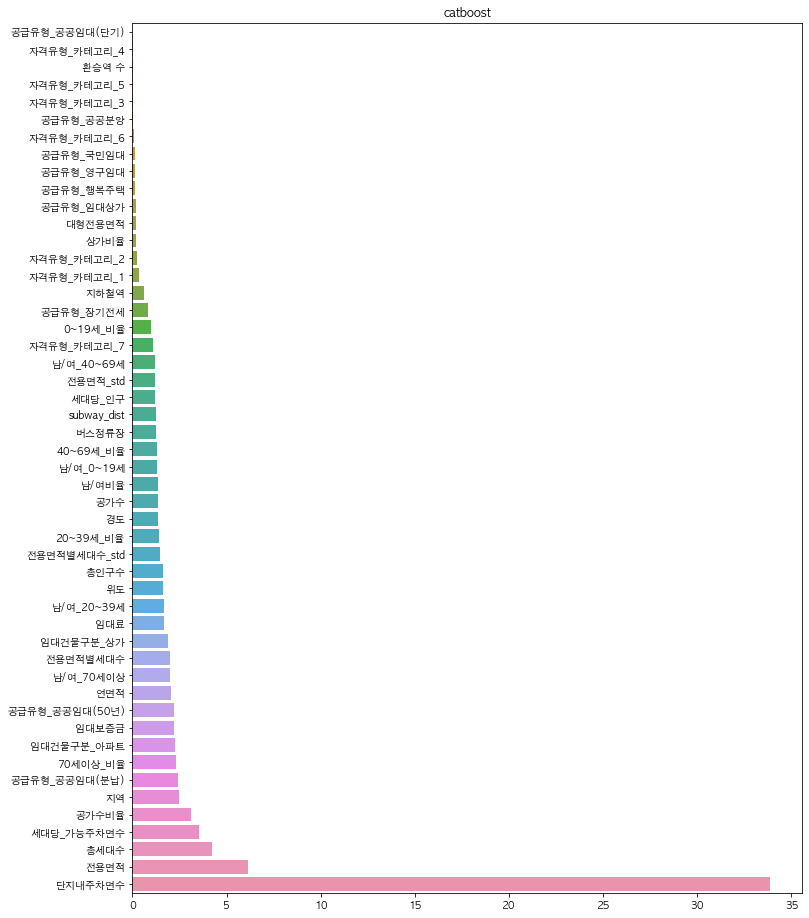

In [228]:
plt.figure(figsize=(12,16))
sns.barplot(y = X.columns[np.argsort(model2.feature_importances_)], x = list(model2.feature_importances_[np.argsort(model2.feature_importances_)]))
plt.title("catboost")
plt.show()

In [ ]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [ ]:
data.shape

## 1차원

### train

In [ ]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).mean()['전용면적별세대수']).reset_index()

## 은영이랑 달라지는 부분

### 전용면적, 전용면적별세대수 

In [ ]:
tr_gr = tr.merge(rawtrain.groupby("단지코드").mean().reset_index()[["단지코드","전용면적",'전용면적별세대수','임대료',"임대보증금"]], left_on = "단지코드",right_on= "단지코드", how = "left")
tst_gr = tst.merge(rawtest.groupby("단지코드").mean().reset_index()[["단지코드","전용면적",'전용면적별세대수','임대료',"임대보증금"]], left_on = "단지코드",right_on= "단지코드", how = "left")

### 전용면적, 전용면적별세대수 std

In [ ]:
tr_gr["전용면적_std"] = rawtrain.groupby("단지코드").std().reset_index()["전용면적"]
tr_gr["전용면적별세대수_std"] = rawtrain.groupby("단지코드").std().reset_index()["전용면적별세대수"]
tr_gr["임대보증금_std"] = rawtrain.groupby("단지코드").std().reset_index()["임대보증금"]
tr_gr["임대료_std"] = rawtrain.groupby("단지코드").std().reset_index()["임대료"]

tst_gr["전용면적_std"] = rawtest.groupby("단지코드").std().reset_index()["전용면적"]
tst_gr["전용면적별세대수_std"] = rawtest.groupby("단지코드").std().reset_index()["전용면적별세대수"]
tst_gr["임대보증금_std"] = rawtest.groupby("단지코드").std().reset_index()["임대보증금"]
tst_gr["임대료_std"] = rawtest.groupby("단지코드").std().reset_index()["임대료"]

tr_gr.loc[tr_gr.전용면적_std.isna(),"전용면적_std"] = 0
tr_gr.loc[tr_gr.전용면적별세대수_std.isna(),"전용면적별세대수_std"] = 0
tr_gr.loc[tr_gr.임대보증금_std.isna(),"임대보증금_std"] = 0
tr_gr.loc[tr_gr.임대료_std.isna(),"임대료_std"] = 0